In [91]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
def resize_image_by_ratio(image_path, ratio):
    # Open the image file
    original_image = Image.open(image_path)

    if original_image.size[0] < original_image.size[1]:
        new_image = original_image.rotate(90)
    else:
        new_image = original_image
    # Get the original dimensions
    original_width, original_height = new_image.size

    # Calculate the new dimensions based on the ratio
    new_width = int(original_width * ratio)
    new_height = int(original_height * ratio)

    # Resize the image
    resized_image = new_image.resize((new_width, new_height))

    return resized_image


In [113]:


def load_image_data():
    data_path = "/home/xiao/code/XiaoniuZhangSlb/Malaria_Classification/raw_data/NIH_binary_classify"
    classes = {'uninfected':0, 'infected':1}
    imgs = []
    labels = []
    ratio = 0.0625
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0 or elt.find('.tiff') > 0]
        for img in tqdm(images_path):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = resize_image_by_ratio(path, ratio)
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    # num_classes = len(set(labels))
    # y = to_categorical(labels, num_classes)
    y = np.array(labels)
    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test


In [114]:
X_train, y_train, X_val, y_val, X_test, y_test = load_image_data()


100%|██████████| 4897/4897 [07:43<00:00, 10.57it/s]


In [137]:
from collections import Counter

# Example list
my_list = [1, 2, 3, 1, 2, 3, 4, 5, 1, 1, 2]

# Use Counter to count occurrences of each element
element_counts = Counter(y_test)

# Print the result
for element, count in element_counts.items():
    print(f"{element}: {count} times")


1: 811 times
0: 195 times


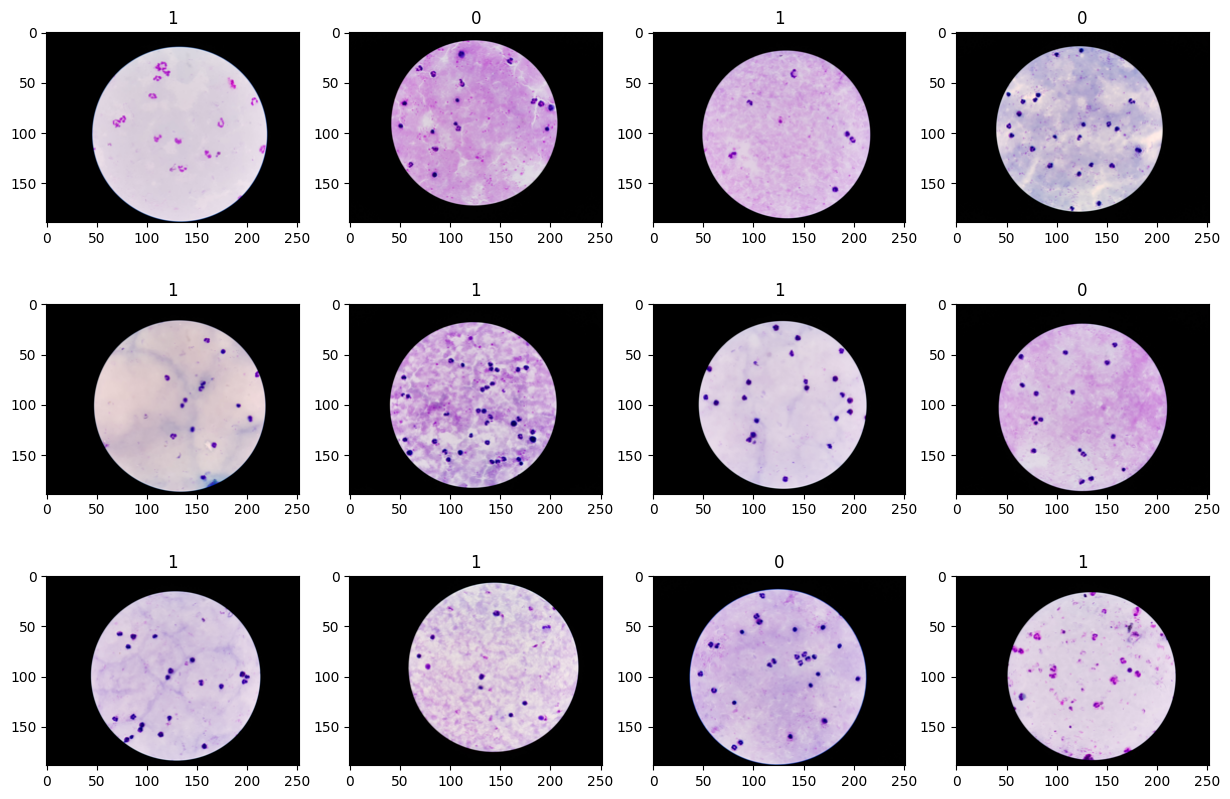

In [116]:
# Let's plot few images to see what they look like
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(3,4, i+1)
    img = X_train[i]
    label = y_train[i]
    plt.imshow(img)
    plt.title(label)


In [117]:
### Normalizing pixels' intensities
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.


In [139]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Create a simple CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(189, 252, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation="relu"))
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))


In [140]:

# Compile the model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


In [141]:
from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train, y_train,
    batch_size=32, verbose=1,
    epochs=5,  # Limiting to 5 epochs as per the instructions
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/5
120/120 [==============================] - 29s 238ms/step - loss: 0.3367 - accuracy: 0.8651 - val_loss: 0.1843 - val_accuracy: 0.9064
Epoch 2/5
120/120 [==============================] - 25s 210ms/step - loss: 0.1465 - accuracy: 0.9336 - val_loss: 0.1503 - val_accuracy: 0.9329
Epoch 3/5
120/120 [==============================] - 24s 201ms/step - loss: 0.0820 - accuracy: 0.9689 - val_loss: 0.1946 - val_accuracy: 0.9329
Epoch 4/5
120/120 [==============================] - 24s 202ms/step - loss: 0.0377 - accuracy: 0.9877 - val_loss: 0.1973 - val_accuracy: 0.9354
Epoch 5/5
120/120 [==============================] - 24s 201ms/step - loss: 0.0129 - accuracy: 0.9956 - val_loss: 0.2498 - val_accuracy: 0.9238


: 

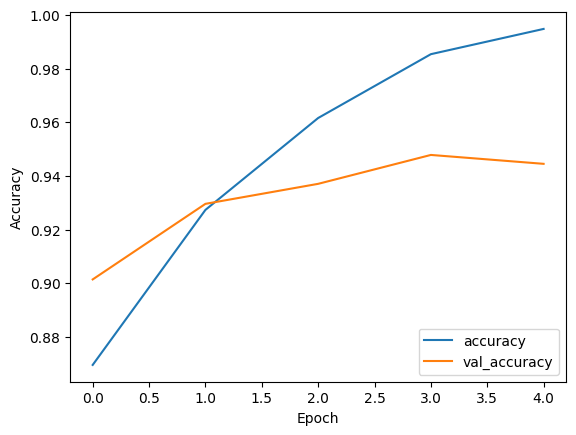

In [127]:
# Plot training history
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()


In [128]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)


(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

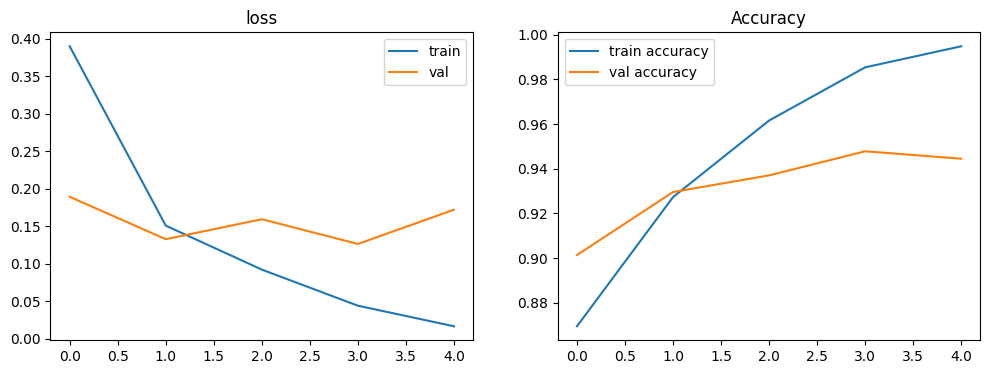

In [129]:
plot_history(history)


In [138]:
# YOUR CODE HERE

y_pred = model.predict(X_test)


# Evaluate accuracy using Keras metrics
accuracy = tf.keras.metrics.CategoricalAccuracy()(y_test, y_pred).numpy()
print("Accuracy on the test set:", accuracy)


32/32 [==============================] - 1s 41ms/step
Accuracy on the test set: 0.0


In [132]:
y_test


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    "path/to/malaria_dataset",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

validation_generator = validation_datagen.flow_from_directory(
    "path/to/malaria_dataset",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
)

# Create a simple CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Train the model
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=validation_generator,
)

# Plot training history
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()
